In [1]:
"""
using SST* to generate near-optimal paths in specified environment
"""
import argparse
from sparse_rrt import _sst_module
from sparse_rrt.systems import standard_cpp_systems
import numpy as np
import time
import pickle
from sparse_rrt.systems.acrobot import Acrobot, AcrobotDistance
from sparse_rrt.systems.point import Point


# set up the environment

env = standard_cpp_systems.CartPole()
state_bounds = env.get_state_bounds()
min_time_steps = 10
max_time_steps = 200
integration_step = 0.002
max_iter = 100000
low = []
high = []
for i in range(len(state_bounds)):
    low.append(state_bounds[i][0])
    high.append(state_bounds[i][1])
## TODO: add other env
paths = []
# randomly sample collision-free start and goal

# write new bound to restrict the state dimension
max_dist = (high[0]-low[0]) / 2
#low[0] = low[0] / 2.
#high[0] = high[0] / 2.
print('trial')
start = np.random.uniform(low=low, high=high)
#distance = np.random.uniform(low=-max_dist, high=max_dist)
end = np.random.uniform(low=low, high=high)
start[1] = 0.
start[3] = 0.
end[1] = 0.
end[3] = 0.
#end[0] = start[0] + distance
#bound_threshold = 5
#if end[0] < low[0] + bound_threshold:
#    end[0] = low[0] + bound_threshold
#if end[0] > high[0] - bound_threshold:
#    end[0] = high[0] - bound_threshold
    
#start = np.array([14.28975866,0., 3.11065249,  0.        ])
#end = np.array([-2.99942229,  0.,         -1.5675782,   0.        ])
print('start:')
print(start)
print('end:')
print(end)
planner = _sst_module.SSTWrapper(
    state_bounds=env.get_state_bounds(),
    control_bounds=env.get_control_bounds(),
    distance=env.distance_computer(),
    start_state=start,
    goal_state=end,
    goal_radius=1.5,
    random_seed=0,
    sst_delta_near=2.0,
    sst_delta_drain=1.2
)
# generate a path by using SST to plan for some maximal iterations
time0 = time.time()
for iter in range(max_iter):
    #if iter % 1000 == 0:
    #    # from time to time use the goal
    #    sample = end
    #    planner.step_with_sample(env, sample, min_time_steps, max_time_steps, integration_step)
    #else:
    #    #sample = np.random.uniform(low=low, high=high)
    #    #planner.step_with_sample(env, sample, min_time_steps, max_time_steps, integration_step)
    planner.step(env, min_time_steps, max_time_steps, integration_step)
    #planner.step_with_sample(env, sample, min_time_steps, max_time_steps, integration_step)
    solution = planner.get_solution()
    #if solution is not None:
    #    break
print('spent time: %f' % (time.time() - time0))
solution = planner.get_solution()
if solution is None:
    print('Not found.')
else:
    print('path %d: succeeded.' % (i))
    path, controls, costs = solution
    print(path)




trial
start:
[9.97083884 0.         1.80542116 0.        ]
end:
[22.41964357  0.          0.28146578  0.        ]
spent time: 15.803376
path 3: succeeded.
[[ 9.97083884  0.          1.80542116  0.        ]
 [10.04837653  1.41074692  1.79303957 -0.22606682]
 [11.70667013  8.1555872   1.59863073 -0.95613751]
 [14.12702656 12.68375118  1.28515989 -1.80098803]
 [15.84530729 14.65087669  1.0380498  -2.        ]
 [17.22829126 12.95286564  0.84001172 -1.93612758]
 [20.6932369   6.81213295  0.31212912 -0.87567926]
 [21.54025204  2.32662577  0.25592919  0.29165814]
 [21.73179657 -0.20212084  0.36134556  0.8660472 ]]


In [2]:
# visualize the path
"""
Given a list of states, render the environment
"""
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.patches as patches
from IPython.display import HTML
from visual.visualizer import Visualizer



class CartPoleVisualizer(Visualizer):
    def __init__(self, system, params):
        super(CartPoleVisualizer, self).__init__(system, params)
        self.dt = 0.05

    def _init(self):
        # clear the current ax
        ax = plt.gca()
        ax.clear()
        # add patches
        state = self.states[0]
        self.pole = patches.Rectangle((state[0]-self.params['pole_w']/2,self.params['cart_h']),\
                                       self.params['pole_w'],self.params['pole_l'],\
                                      linewidth=.5,edgecolor='red',facecolor='red')
        self.cart = patches.Rectangle((state[0]-self.params['cart_w']/2,0),\
                                       self.params['cart_w'],self.params['cart_h'],\
                                      linewidth=.5,edgecolor='blue',facecolor='blue')
        self.recs = []
        self.recs.append(self.pole)
        self.recs.append(self.cart)
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor='black',facecolor='black')
            self.recs.append(obs)
            ax.add_patch(obs)
        # transform pole according to state
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.pole.set_transform(t)
        ax.add_patch(self.pole)
        ax.add_patch(self.cart)
        return self.recs
    def _animate(self, i):
        ax = plt.gca()
        ax.set_xlim(-40, 40)
        ax.set_ylim(-20, 20)
        state = self.states[i]
        self.recs[0].set_xy((state[0]-self.params['pole_w']/2,self.params['cart_h']))
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], self.params['cart_h'], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.recs[0].set_transform(t)
        self.recs[1].set_xy((state[0]-self.params['cart_w']/2,params['cart_h']))
        # print location of cart
        return self.recs


 
    def animate(self, states, actions, obstacles):
        '''
        given a list of states, actions and obstacles, animate the robot
        '''
        # transform the waypoint states and actions into trajectory
        traj = []
        for i in range(len(states)-1):
            s = states[i]
            action = actions[i]
            sT = states[i+1]
            # propogate until reaching next state
            while True:
                traj.append(s)
                #print("porpagating...")
                #print(s)
                #print('st:')
                #print(sT)
                s = self.system.propagate(s, action, 1, self.params['integration_step'])
                if np.linalg.norm(s-sT) == 0.:
                    break
        traj = np.array(traj)
        print("animating...")
        # animate
        self.states = traj
        self.obs = obstacles
        ani = animation.FuncAnimation(plt.gcf(), self._animate, range(1, len(self.states)),
                                      interval=self.dt*100, blit=True, init_func=self._init,
                                      repeat=True)
        return ani


animating...


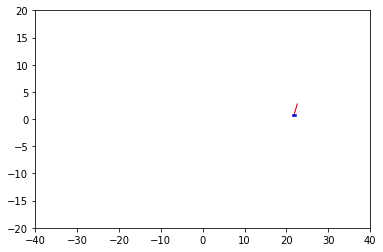

In [3]:
%matplotlib inline
params = {}
params['pole_l'] = 2.5
params['pole_w'] = 0.1
params['cart_w'] = 1.
params['cart_h'] = 0.5
params['obs_w'] = 4
params['obs_h'] = 4
params['integration_step'] = 0.002
obs_list = []
# import our python implementation of CartPole
from env.cartpole_obs import CartPoleObs
system = CartPoleObs([])
vis = CartPoleVisualizer(system, params)
states, actions, costs = solution
anim = vis.animate(states, actions, obs_list)
HTML(anim.to_html5_video())